# CNN model testing
Used to test audio that are mixes of songs and ads.

Requires saved models from either:
* `cnn_mfcc.ipynb`
* `cnn_mfcc_delta.ipynb`
* `cnn_raw.ipynb`

Requires audio from:
* `resampleAudio_testing.m`
* `resampleRun_testing.m`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy
from scipy.io import wavfile

In [2]:
# Load audio file
song_dir = "resampled_testing_songs"
ad_dir   = "resampled_testing_ads"
sr = 44100
song_data = []
ad_data = []

In [3]:
# get songs
num_songs = 0
for filename in os.listdir(song_dir):
    # Check if the file is a WAV file
    if filename.endswith('.wav'):
        num_songs += 1
        # Construct the full path to the file
        filepath = os.path.join(song_dir, filename)
        [data, sr_dc] = librosa.load(filepath, sr=sr)
        song_data.append(data)
print(f"Num Songs is: {num_songs}")

Num Songs is: 4


In [4]:
# get ads
num_ads = 0
for filename in os.listdir(ad_dir):
    # Check if the file is a WAV file
    if filename.endswith('.wav'):
        num_ads += 1
        numClips = 0
        # Construct the full path to the file
        filepath = os.path.join(ad_dir, filename)
        [data, sr_dc] = librosa.load(filepath, sr=sr)
        ad_data.append(data)
print(f"Num Ads is: {num_ads}")

Num Ads is: 3


In [5]:
# Define our CNNs
class mfcc_CNN(nn.Module):
    def __init__(self):
        super(mfcc_CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(6784, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output into a 1D vector for use in the fully connected layers
        size = x.size()[1:]  #all size except batchSize
        numFeatures = 1
        for s in size:
            numFeatures *= s
        x = x.view(-1, numFeatures)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        #x = torch.sigmoid(self.fc2(x))
        x = self.fc2(x)
        return x
        
class mfcc_d_CNN(nn.Module):
    def __init__(self):
        super(mfcc_d_CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(6784, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output into a 1D vector for use in the fully connected layers
        size = x.size()[1:]  #all size except batchSize
        numFeatures = 1
        for s in size:
            numFeatures *= s
        x = x.view(-1, numFeatures)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        #x = torch.sigmoid(self.fc2(x))
        x = self.fc2(x)
        return x
        
class raw_CNN(nn.Module):
    def __init__(self):
        super(raw_CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv1d(1,  32,  kernel_size=10, padding=1)
        self.conv2 = nn.Conv1d(32, 64,  kernel_size=5, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.AvgPool1d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(3527808, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output for fully connected layers
        size = x.size()[1:]  #all size except batchSize
        numFeatures = 1
        for s in size:
            numFeatures *= s
        x = x.view(-1, numFeatures)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# define get window function
def get_window(audio, begin, window_size):
    return audio[(begin):(begin+window_size)]

In [7]:
# load Model
mfcc_model_name       = "cnn_mfcc_model_testing.pth"
mfcc_delta_model_name = "cnn_mfcc_delta_model_testing.pth"
raw_model_name        = "cnn_raw_model_batch_100_epoch_5.pth"

# Load the state dictionary
state_dict_1 = torch.load(mfcc_model_name)
state_dict_2 = torch.load(mfcc_delta_model_name)
state_dict_3 = torch.load(raw_model_name)

# Create an instance of model
model_mfcc   = mfcc_CNN()
model_mfcc_d = mfcc_d_CNN()
model_raw    = raw_CNN()

# Load the state dictionary into the model
model_mfcc.load_state_dict(state_dict_1)
model_mfcc_d.load_state_dict(state_dict_2)
model_raw.load_state_dict(state_dict_3)

# Set the model in evaluation mode
model_mfcc.eval()
model_mfcc_d.eval()
model_raw.eval()

# Initialize parameters
seconds_per_window = 5

win_length = 5*sr

win_div = 20

window_stride = win_length//win_div

# mix together alternating songs and ads
audio = []
for i in range(len(song_data) + len(ad_data)):
    if(i % 2 == 0):
        audio.extend(song_data[i//2])
    else:
        audio.extend(ad_data[i//2])
audio = np.array(audio).astype(dtype=np.float32)
audio = np.pad(audio, (win_length, win_length), mode='constant')

print(f"audio length is: {audio.shape}")

audio length is: (44939861,)


In [8]:
wavfile.write(os.path.join("testing_audio", "complex.wav"), sr, audio)

In [9]:
# evaluate audio (MFCC)
temp = librosa.feature.mfcc(y=audio[0:win_length], sr=sr, n_mfcc=13)[1:].T
mfccs = np.empty((1, 1, temp.shape[0], temp.shape[1]), dtype=np.float32)
print(f"tensor shape: {mfccs.shape}")

audio_eval_mfcc = []
song_confidence_mfcc = []
ad_confidence_mfcc = []

for i in range(0, len(audio) - win_length, window_stride):
    window = get_window(audio, i, win_length)
    mfccs[0][0] = librosa.feature.mfcc(y=window, sr=sr, n_mfcc=13)[1:].T
    mfccs_tensor = torch.tensor(mfccs, dtype=torch.float32)
    output = model_mfcc(mfccs_tensor)
    prediction = torch.max(output.data, 1)
    audio_eval_mfcc.append([0 if x == 0 else 1 for x in prediction.indices])
    ad_confidence_mfcc.append(output.data[0][0])
    song_confidence_mfcc.append(output.data[0][1])

tensor shape: (1, 1, 431, 12)


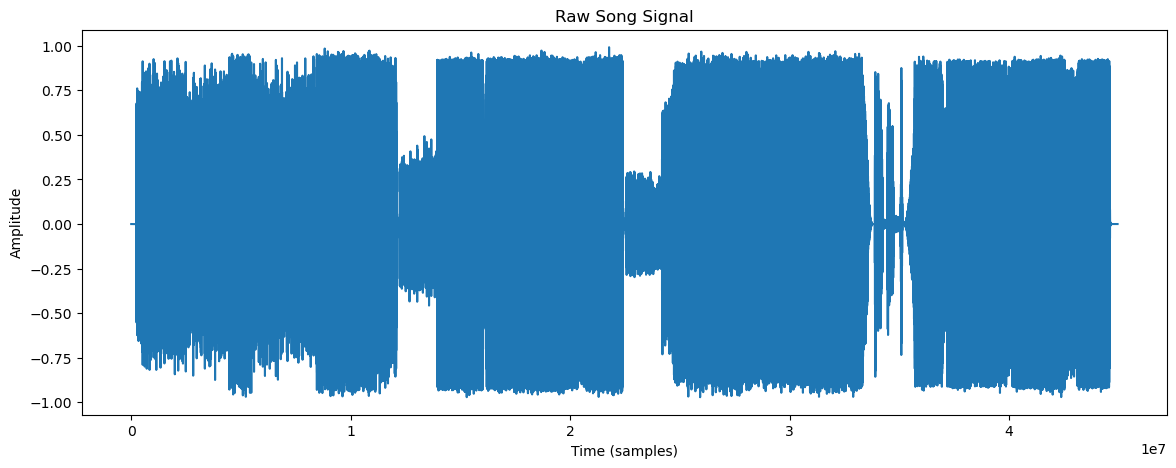

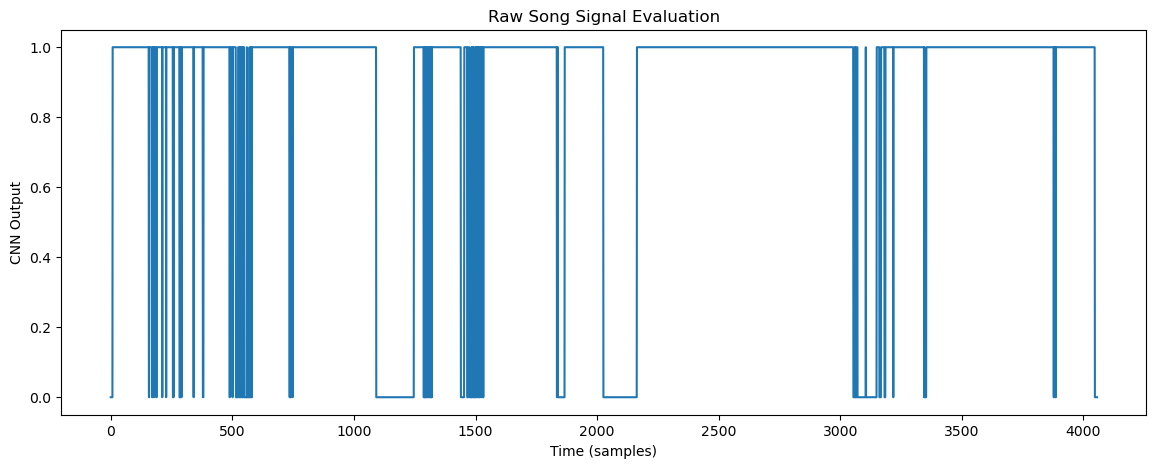

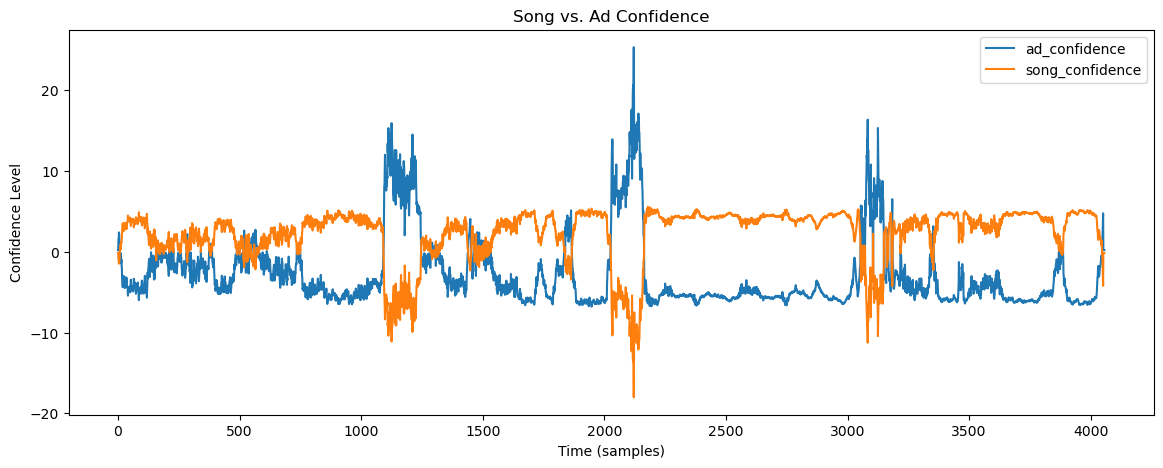

In [10]:
#plot song (MFCC)
plt.figure(figsize=(14, 5))
plt.plot(audio)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Raw Song Signal')
plt.savefig(os.path.join("graphics", "mfcc_audio.png"), transparent=True)
plt.show()


#plot eval
plt.figure(figsize=(14, 5))
plt.plot(audio_eval_mfcc)
plt.xlabel('Time (samples)')
plt.ylabel('CNN Output')
plt.title('Raw Song Signal Evaluation')
plt.savefig(os.path.join("graphics", "mfcc_eval.png"), transparent=True)
plt.show()

#plot confidences
plt.figure(figsize=(14, 5))
plt.plot(ad_confidence_mfcc, label='ad_confidence')
plt.plot(song_confidence_mfcc, label='song_confidence')
plt.legend(loc='upper right')
plt.xlabel('Time (samples)')
plt.ylabel('Confidence Level')
plt.title('Song vs. Ad Confidence')
plt.savefig(os.path.join("graphics", "mfcc_confidence.png"), transparent=True)
plt.show()

Original Length: 44939861 samples
New Length: 38631600 samples


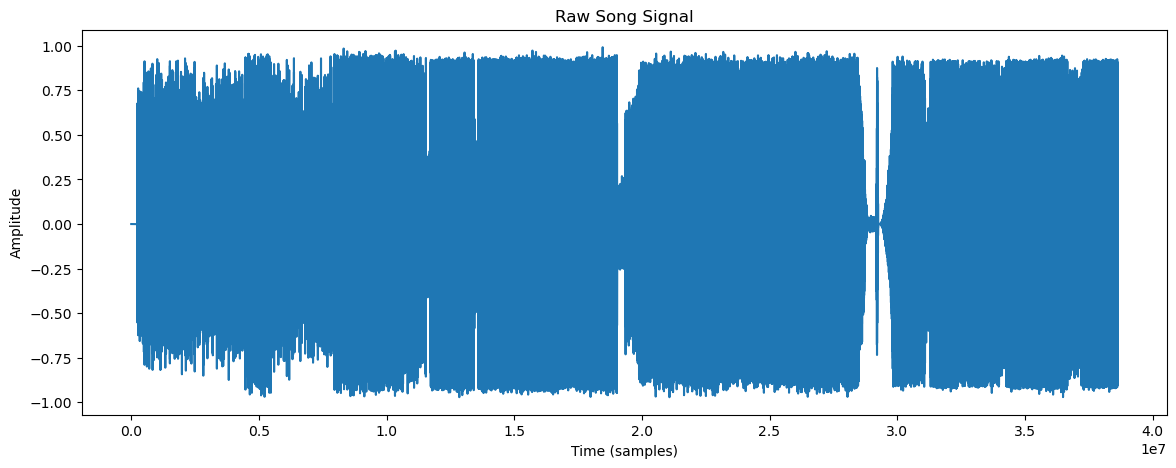

In [11]:
# remove Ads (MFCC)
audio_out_mfcc = []
audio_out_mfcc.extend(audio[0:win_length])  
song_val = [1]
threshold = win_div//2
for i in range(win_div, len(audio_eval_mfcc) - win_div):
    count = 0
    for j in range(i-(win_div//2), i+(win_div//2)):
        if(audio_eval_mfcc[j] == song_val):
            count += 1
    # if majority of overlapping windows say song
    if(count > threshold):
        audio_out_mfcc.extend(audio[(window_stride*i):(window_stride*(i+1))])

print(f"Original Length: {len(audio)} samples")
print(f"New Length: {len(audio_out_mfcc)} samples")

plt.figure(figsize=(14, 5))
plt.plot(audio_out_mfcc)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Raw Song Signal')
plt.show()

audio_out_mfcc = np.array(audio_out_mfcc, dtype=np.float32)
wavfile.write(os.path.join("testing_audio", "mfcc_output.wav"), sr, audio_out_mfcc)

In [12]:
# evaluate audio (MFCC + delta)
temp = librosa.feature.mfcc(y=audio[0:win_length], sr=sr, n_mfcc=13)[1:].T
mfccs_d = np.empty((1, 3, temp.shape[0], temp.shape[1]), dtype=np.float32)
print(f"tensor shape: {mfccs_d.shape}")

audio_eval_mfcc_d = []
song_confidence_mfcc_d = []
ad_confidence_mfcc_d = []

for i in range(0, len(audio) - win_length, window_stride):
    window = get_window(audio, i, win_length)
    mfccs_d[0][0] = librosa.feature.mfcc(y=window, sr=sr, n_mfcc=13)[1:].T
    mfccs_d[0][1] = librosa.feature.delta(mfccs_d[0][0].T).T
    mfccs_d[0][2] = librosa.feature.delta(mfccs_d[0][0].T, order=2).T
    mfccs_tensor = torch.tensor(mfccs_d, dtype=torch.float32)
    output = model_mfcc_d(mfccs_tensor)
    prediction = torch.max(output.data, 1)
    audio_eval_mfcc_d.append([0 if x == 0 else 1 for x in prediction.indices])
    ad_confidence_mfcc_d.append(output.data[0][0])
    song_confidence_mfcc_d.append(output.data[0][1])

tensor shape: (1, 3, 431, 12)


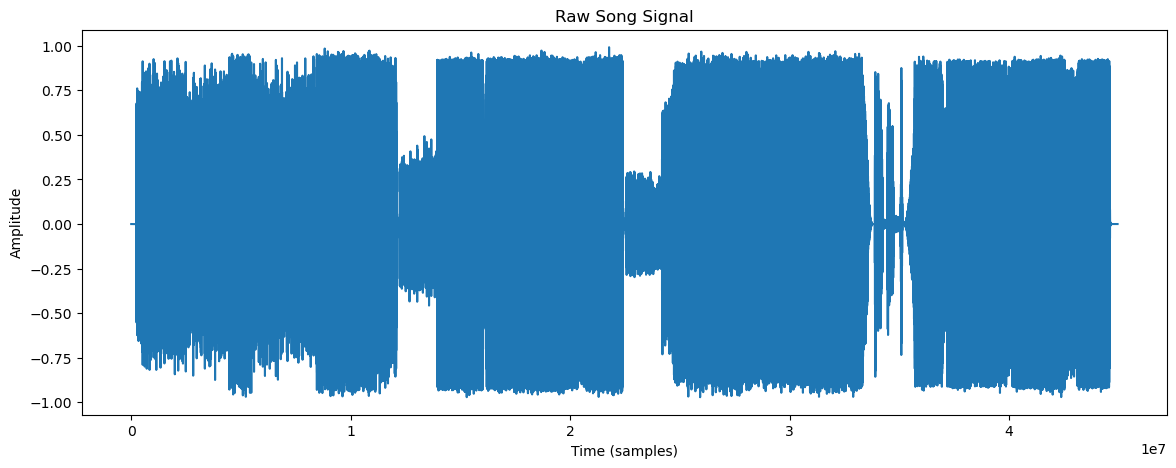

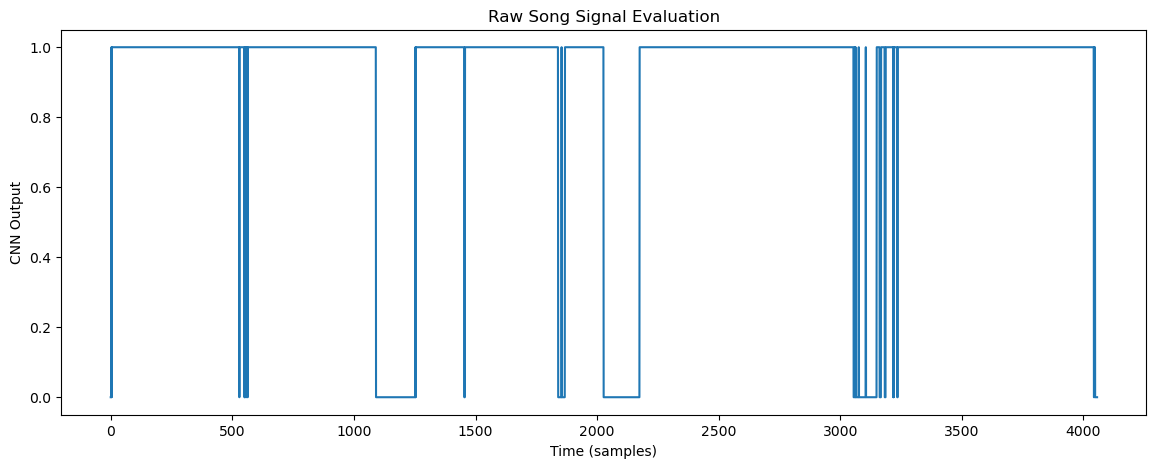

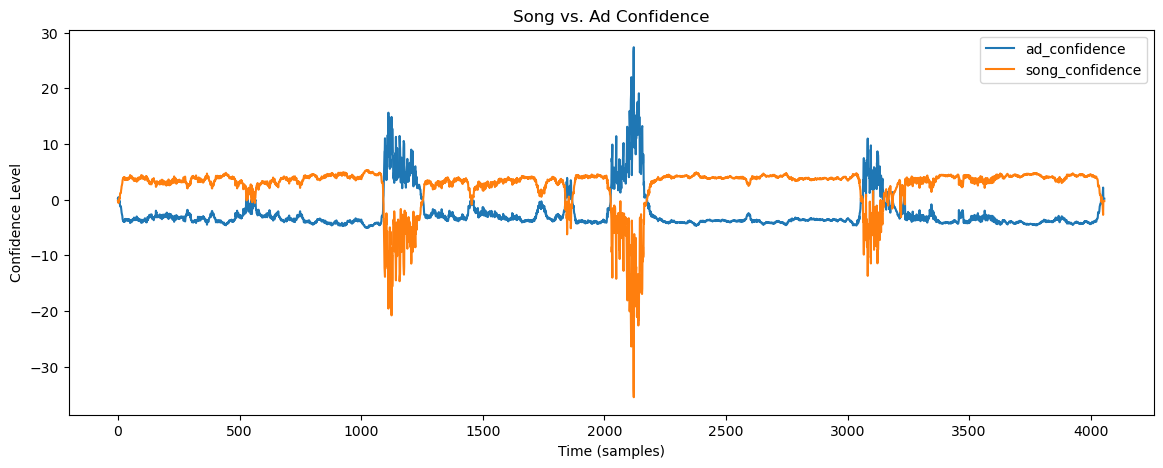

In [13]:
#plot song (MFCC + delta)
plt.figure(figsize=(14, 5))
plt.plot(audio)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Raw Song Signal')
plt.savefig(os.path.join("graphics", "mfcc_d_audio.png"), transparent=True)
plt.show()

#plot eval
plt.figure(figsize=(14, 5))
plt.plot(audio_eval_mfcc_d)
plt.xlabel('Time (samples)')
plt.ylabel('CNN Output')
plt.title('Raw Song Signal Evaluation')
plt.savefig(os.path.join("graphics", "mfcc_d_eval.png"), transparent=True)
plt.show()

#plot confidences
plt.figure(figsize=(14, 5))
plt.plot(ad_confidence_mfcc_d, label='ad_confidence')
plt.plot(song_confidence_mfcc_d, label='song_confidence')
plt.legend(loc='upper right')
plt.xlabel('Time (samples)')
plt.ylabel('Confidence Level')
plt.title('Song vs. Ad Confidence')
plt.savefig(os.path.join("graphics", "mfcc_d_confidence.png"), transparent=True)
plt.show()

Original Length: 44939861 samples
New Length: 39712050 samples


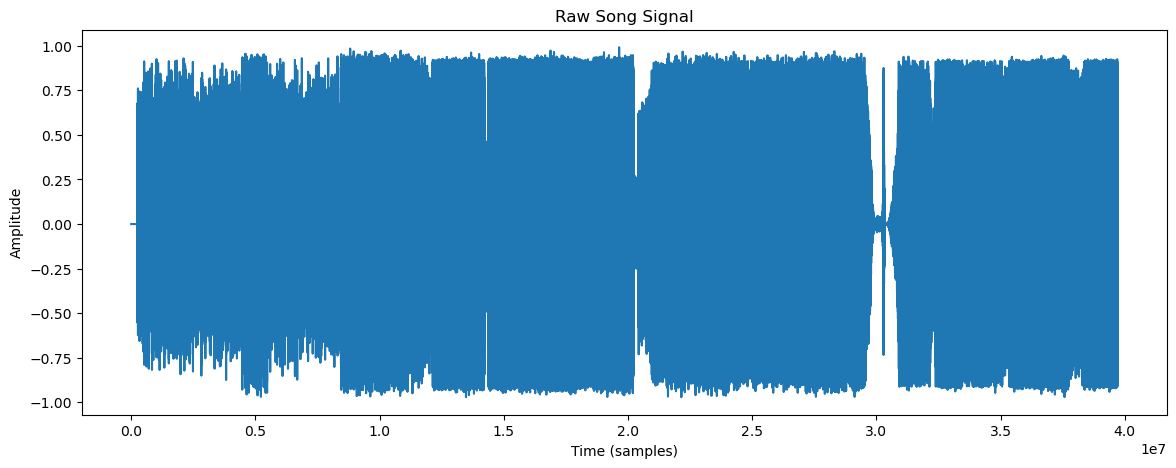

In [14]:
# remove Ads (MFCC + delta)
audio_out_mfcc_d = []
audio_out_mfcc_d.extend(audio[0:win_length])  
song_val = [1]
threshold = win_div//2
for i in range(win_div, len(audio_eval_mfcc_d) - win_div):
    count = 0
    for j in range(i-(win_div//2), i+(win_div//2)):
        if(audio_eval_mfcc_d[j] == song_val):
            count += 1
    # if majority of overlapping windows say song
    if(count > threshold):
        audio_out_mfcc_d.extend(audio[(window_stride*i):(window_stride*(i+1))])

print(f"Original Length: {len(audio)} samples")
print(f"New Length: {len(audio_out_mfcc_d)} samples")

plt.figure(figsize=(14, 5))
plt.plot(audio_out_mfcc_d)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Song with Ads Remo')
plt.show()

audio_out_mfcc_d = np.array(audio_out_mfcc_d, dtype=np.float32)
wavfile.write(os.path.join("testing_audio", "mfcc_d_output.wav"), sr, audio_out_mfcc_d)

In [ ]:
# evaluate audio (raw)
window_raw = np.empty((1, 1, win_length))
print(f"tensor shape: {window_raw.shape}")

audio_eval_raw = []
song_confidence_raw = []
ad_confidence_raw = []

for i in range(0, len(audio) - win_length, window_stride):
    window_raw[0] = get_window(audio, i, win_length)
    raw_tensor = torch.tensor(window_raw, dtype=torch.float32)
    output = model_raw(raw_tensor)
    prediction = torch.max(output.data, 1)
    audio_eval_raw.append([0 if x == 0 else 1 for x in prediction.indices])
    ad_confidence_raw.append(output.data[0][0])
    song_confidence_raw.append(output.data[0][1])

tensor shape: (1, 1, 220500)


In [ ]:
#plot song
plt.figure(figsize=(14, 5))
plt.plot(audio)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Raw Song Signal')
plt.savefig(os.path.join("graphics", "raw_audio.png"), transparent=True)
plt.show()

#plot eval
plt.figure(figsize=(14, 5))
plt.plot(audio_eval_raw)
plt.xlabel('Time (samples)')
plt.ylabel('CNN Output')
plt.title('Raw Song Signal Evaluation')
plt.savefig(os.path.join("graphics", "raw_eval.png"), transparent=True)
plt.show()

#plot confidences
plt.figure(figsize=(14, 5))
plt.plot(ad_confidence_raw, label='ad_confidence')
plt.plot(song_confidence_raw, label='song_confidence')
plt.legend(loc='upper right')
plt.xlabel('Time (samples)')
plt.ylabel('Confidence Level')
plt.title('Song vs. Ad Confidence')
plt.savefig(os.path.join("graphics", "raw_confidence.png"), transparent=True)
plt.show()